In [440]:
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
import time
#import seaborn as sns
#sns.set(color_codes=True)
import numpy as np
from datetime import datetime, date
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import SGDClassifier

In [451]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
dataset = train.drop('Business_Sourced', axis=1)
#dataset = train
dataset = dataset.append(test, ignore_index=True)
dataset = dataset.drop('ID', axis=1)
#dataset.head(100)
print (train.shape, test.shape, dataset.shape)

(9527, 23) (5045, 22) (14572, 21)


In [452]:
print ('=== Train Null Counts ===')
#print train.isnull().sum()
print ('\n=== Test Null Counts === ')
#print test.isnull().sum()
print ('\n=== Dataset Null Counts === ')
print (dataset.isnull().sum())
#print dataset.dtypes

=== Train Null Counts ===

=== Test Null Counts === 

=== Dataset Null Counts === 
Office_PIN                        0
Application_Receipt_Date          0
Applicant_City_PIN              131
Applicant_Gender                 89
Applicant_BirthDate              96
Applicant_Marital_Status        103
Applicant_Occupation           2225
Applicant_Qualification         130
Manager_DOJ                    1507
Manager_Joining_Designation    1507
Manager_Current_Designation    1507
Manager_Grade                  1507
Manager_Status                 1507
Manager_Gender                 1507
Manager_DoB                    1507
Manager_Num_Application        1507
Manager_Num_Coded              1507
Manager_Business               1507
Manager_Num_Products           1507
Manager_Business2              1507
Manager_Num_Products2          1507
dtype: int64


In [453]:
def calculate_age(born):
    born = datetime.strptime(born, '%m/%d/%Y')
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))
def get_month(receipt_date):
    receipt_date = datetime.strptime(receipt_date, '%m/%d/%Y')
    return receipt_date.month
def get_products_bin(num):
    if num >=3 :
        return 3
    return x
def shorten_qualification(x):
    if x in ['Class X', 'Others']:
        return 'Others'
    elif x == 'Class XII':
        return x
    return 'Graduate'
def shorten_occupation(x):
    if x not in ['Salaried', 'Business']:
        return 'Others'
    return x

def manager_grade(x):
    if x == 1:
        return 2
    elif x >= 5:
        return 5
    return x
def manager_level(x):
    if x in ['Level 5', 'Level 6', 'Level 7', 'Other']:
        return 'Level 4'
    return x

def products(x):
    if x > 0 and x <= 25:
        return 1
    elif x > 25 and x <= 50:
        return 2
    elif x > 50:
        return 3
    return x

def num_coded(x):
    if x >= 3:
        return 3
    return x

def application(x):
    if x in [3,4]:
        return 3
    elif x > 4:
        return 4
    return x

In [444]:
dataset.head()

,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Applicant_Gender,Applicant_BirthDate,Applicant_Marital_Status,Applicant_Occupation,Applicant_Qualification,Manager_DOJ,Manager_Joining_Designation,...,Manager_Grade,Manager_Status,Manager_Gender,Manager_DoB,Manager_Num_Application,Manager_Num_Coded,Manager_Business,Manager_Num_Products,Manager_Business2,Manager_Num_Products2
0,842001,4/16/2007,844120.0,M,12/19/1971,M,Others,Graduate,11/10/2005,Level 1,...,3.0,Confirmation,M,2/17/1978,2.0,1.0,335249.0,28.0,335249.0,28.0
1,842001,4/16/2007,844111.0,M,2/17/1983,S,Others,Class XII,11/10/2005,Level 1,...,3.0,Confirmation,M,2/17/1978,2.0,1.0,335249.0,28.0,335249.0,28.0
2,800001,4/16/2007,844101.0,M,1/16/1966,M,Business,Class XII,5/27/2006,Level 1,...,2.0,Confirmation,M,3/3/1969,0.0,0.0,357184.0,24.0,357184.0,24.0
3,814112,4/16/2007,814112.0,M,2/3/1988,S,Salaried,Class XII,8/21/2003,Level 1,...,4.0,Confirmation,F,8/14/1978,0.0,0.0,318356.0,22.0,318356.0,22.0
4,814112,4/16/2007,815351.0,M,7/4/1985,M,Others,Class XII,5/8/2006,Level 1,...,2.0,Confirmation,M,2/7/1971,2.0,1.0,230402.0,17.0,230402.0,17.0


In [445]:
#dataset.hist(column='Manager_Num_Products')
#dataset.hist(column='Manager_Num_Products2')
#dataset.hist(column='Manager_Business')
#dataset.hist(column='Manager_Business2')
#dataset.hist(column='Manager_Num_Coded')
# dataset['Business']= (dataset['Manager_Business2']+ dataset['Manager_Business'])
#dataset.hist(column='Business')

In [454]:
dataset['Applicant_Qualification'] = dataset['Applicant_Qualification'].apply(lambda x: shorten_qualification(str(x)))
dataset['Business'] =  dataset['Manager_Business'] + dataset['Manager_Business2']
dataset['Products'] = dataset['Manager_Num_Products'] + dataset['Manager_Num_Products2']
dataset['Business'] = (dataset['Business'] - dataset['Business'].mean())/ (dataset['Business'].max() - dataset['Business'].min())
dataset.loc[dataset['Business'].isnull(), 'Business'] = 0
dataset.loc[dataset['Products'].isnull(), 'Products'] = dataset['Products'].median()
dataset['Manager_Grade'] = dataset['Manager_Grade'].apply( lambda x : manager_grade(x))
dataset['Manager_Joining_Designation'] = dataset['Manager_Joining_Designation'].apply(lambda x : manager_level(x))
dataset['Manager_Current_Designation'] = dataset['Manager_Current_Designation'].apply(lambda x : manager_level(x))
dataset['Manager_Num_Coded'] = dataset['Manager_Num_Coded'].apply(lambda x: num_coded(x))
dataset['Manager_Num_Application'] = dataset['Manager_Num_Application'].apply(lambda x : application(x))
dataset['Products'] = dataset['Products'].apply(lambda x : products(x))


#dataset['Applicant_Occupation'] = dataset['Applicant_Occupation'].apply(lambda x : shorten_occupation(str(x)))
dataset['Application_Receipt_Date'] = dataset['Application_Receipt_Date'].apply(lambda x : get_month(x))

dataset.loc[dataset['Applicant_City_PIN'].isnull(), 'Applicant_City_PIN'] = 100000  # Fill Applicant_City_PIN with 100000
dataset.loc[dataset['Applicant_Gender'].isnull(), 'Applicant_Gender'] = 'M'  # Fill Applicant_Gender with M


# Handle Birthday by converting it to Age
dataset['Applicant_Age'] = dataset[dataset['Applicant_BirthDate'].notnull()]['Applicant_BirthDate'].apply(lambda x : calculate_age(str(x)))
dataset.loc[dataset['Applicant_Age'].isnull(), 'Applicant_Age'] = dataset['Applicant_Age'].median()
#dataset['Applicant_Age'] = pd.qcut(dataset['Applicant_Age'], 4, labels=['Fresher', 'Associate', 'Experienced', 'Senior'])

dataset.loc[dataset['Applicant_Marital_Status'].isnull(),'Applicant_Marital_Status'] = 'M' # Fill Marital Status with M
dataset.loc[dataset['Applicant_Occupation'].isnull(), 'Applicant_Occupation'] = 'Unknown' # Make new category for null occupation
dataset.loc[dataset['Applicant_Qualification'].isnull(), 'Applicant_Qualification'] = 'Class XII' # For now assign nulls to class-12

dataset['Manager_Age'] = dataset.loc[dataset['Manager_DoB'].notnull()]['Manager_DoB'].apply(lambda x : calculate_age(str(x)))
dataset.loc[dataset['Manager_Age'].isnull(), 'Manager_Age'] = dataset['Manager_Age'].median()
dataset.loc[dataset['Manager_Gender'].isnull(), 'Manager_Gender'] = 'M'
dataset.loc[dataset['Manager_Num_Coded'].isnull(), 'Manager_Num_Coded'] = dataset['Manager_Num_Coded'].median()
dataset.loc[dataset['Manager_Num_Application'].isnull(), 'Manager_Num_Application'] = dataset['Manager_Num_Application'].median()
dataset.loc[dataset['Manager_Num_Products'].isnull(), 'Manager_Num_Products'] = 0
dataset.loc[dataset['Manager_Num_Products2'].isnull(), 'Manager_Num_Products2'] = 0

dataset['Manager_Business'] = dataset['Manager_Business'].apply(lambda x : str(x))
dataset['Manager_Business2'] = dataset['Manager_Business2'].apply(lambda x : str(x))
dataset['Manager_Age_DOJ'] = dataset.loc[dataset['Manager_DOJ'].notnull()]['Manager_DOJ'].apply(lambda x : get_month(x))
dataset.loc[dataset['Manager_Age_DOJ'].isnull(), 'Manager_Age_DOJ'] = dataset['Manager_Age_DOJ'].median()

dataset['Manager_DoB'] = pd.to_datetime(dataset['Manager_DoB'])
dataset['Manager_DOJ'] = pd.to_datetime(dataset['Manager_DOJ'])
dataset['Manager_Service'] = (dataset['Manager_DOJ'] - dataset['Manager_DoB'])/np.timedelta64(1, 'D')
dataset.loc[dataset['Manager_Service'].isnull(), 'Manager_Service'] = dataset['Manager_Service'].mean()
enc = LabelEncoder()
dataset['Manager_Business'] = enc.fit_transform(dataset['Manager_Business'])
dataset['Manager_Business2'] = enc.fit_transform(dataset['Manager_Business2'])
dataset['Applicant_City_PIN'] = enc.fit_transform(dataset['Applicant_City_PIN'])
dataset['Office_PIN'] = enc.fit_transform(dataset['Office_PIN'])
#dataset['Applicant_Age'] = enc.fit_transform(dataset['Applicant_Age'])

#encode_columns = ['Manager_Business', 'Manager_Business2']
#dataset[encode_columns] = enc.fit_transform(dataset[encode_columns])

dataset = dataset.drop(['Applicant_BirthDate', 'Manager_DoB', 'Manager_DOJ', 'Manager_Business', 'Manager_Business2', 
                       'Manager_Num_Products', 'Manager_Num_Products2'], axis=1)
dummy_columns = [
 'Applicant_Gender',
 'Applicant_Marital_Status',
 'Applicant_Occupation',
 'Applicant_Qualification',
 'Manager_Joining_Designation',
 'Manager_Current_Designation',
 'Manager_Grade',
 'Manager_Status',
 'Manager_Gender',
'Manager_Num_Coded',
    'Manager_Num_Application',
    'Products'
]

dataset =pd.get_dummies(dataset, columns=dummy_columns)
dataset.head()


,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Business,Applicant_Age,Manager_Age,Manager_Age_DOJ,Manager_Service,Applicant_Gender_F,Applicant_Gender_M,...,Manager_Num_Coded_3.0,Manager_Num_Application_0.0,Manager_Num_Application_1.0,Manager_Num_Application_2.0,Manager_Num_Application_3.0,Manager_Num_Application_4.0,Products_0.0,Products_1.0,Products_2.0,Products_3.0
0,95,4,3662,0.046033,44.0,38.0,11.0,10128.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,95,4,3655,0.046033,33.0,38.0,11.0,10128.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,84,4,3652,0.051740,50.0,47.0,5.0,13599.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,89,4,3439,0.041638,28.0,37.0,8.0,9138.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,89,4,3456,0.018754,31.0,45.0,5.0,12874.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [455]:
dataset.head(100)


,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Business,Applicant_Age,Manager_Age,Manager_Age_DOJ,Manager_Service,Applicant_Gender_F,Applicant_Gender_M,...,Manager_Num_Coded_3.0,Manager_Num_Application_0.0,Manager_Num_Application_1.0,Manager_Num_Application_2.0,Manager_Num_Application_3.0,Manager_Num_Application_4.0,Products_0.0,Products_1.0,Products_2.0,Products_3.0
0,95,4,3662,0.046033,44.0,38.0,11.0,10128.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,95,4,3655,0.046033,33.0,38.0,11.0,10128.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,84,4,3652,0.051740,50.0,47.0,5.0,13599.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,89,4,3439,0.041638,28.0,37.0,8.0,9138.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,89,4,3456,0.018754,31.0,45.0,5.0,12874.000000,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,89,4,3440,0.023103,28.0,37.0,1.0,9828.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,95,4,3660,0.040796,47.0,47.0,9.0,12514.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,84,4,3654,-0.010657,32.0,40.0,12.0,11301.000000,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8,18,4,393,0.022299,40.0,50.0,11.0,14136.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,19,4,509,0.180364,34.0,41.0,8.0,10136.000000,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [456]:
print (train.shape, test.shape, dataset.shape)
train_x = dataset.ix[0:train.shape[0]-1,]
train_y = train['Business_Sourced']
#train_x = pd.concat([train_x, train_y], axis=1)
test_x = dataset.ix[train.shape[0]:dataset.shape[0],]
target = 'Business_Sourced'
print (train_x.shape, test_x.shape, train_y.shape)

(9527, 23) (5045, 22) (14572, 52)
(9527, 52) (5045, 52) (9527,)


In [457]:
data = train_x
labels = train_y

In [144]:
# create dataset
dataset = Dataset(data, labels ,test_x)

# initialize RandomForest & LinearRegression 
model_gb = Classifier(dataset=dataset, estimator=GradientBoostingClassifier, parameters={'n_estimators': 1000, 'max_depth': 8}, name='gb')
model_bg = Classifier(dataset=dataset, estimator=BaggingClassifier, parameters={'max_samples': 0.9, 'max_features': 0.9}, name='bg')
#model_rf = Classifier(dataset=dataset, estimator=RandomForestClassifier, parameters={'n_estimators' : 1500, 'max_depth' : 8}, name='rf')
# Stack two models 
# Returns new dataset with out-of-fold predictions
pipeline = ModelsPipeline(model_gb, model_bg, model_rf)
stack_ds = pipeline.stack(k=10,seed=111)

stack_rf = Classifier(dataset=stack_ds, estimator=RandomForestClassifier, parameters={'n_estimators' : 1000, 'max_depth' : 8}, name='rf')
stack_gb = Classifier(dataset=stack_ds, estimator=GradientBoostingClassifier, parameters={'n_estimators': 1500, 'max_depth': 8},name='gb')
#stack_bg = Classifier(dataset=stack_ds, estimator=BaggingClassifier, parameters={'max_samples': 0.9, 'max_features': 0.9}, name='bg')

stack_pipeline = ModelsPipeline(stack_rf, stack_gb)
#weights = stack_pipeline.find_weights(mean_absolute_error)
print('---')
#result1 = stack_pipeline.weight(weights)
result2 = stack_pipeline.mean().execute()

---


In [83]:
# Train LinearRegression on stacked data (second stage)


[ 0.17573542  0.31776667  0.09133005 ...,  0.4543269   0.30326582
  0.39990275]


In [458]:

result_acc = []
result_auc = []
cv = KFold(len(data), n_folds=10, shuffle=False, random_state=None)
for trainindex, testindex in cv:
    randomindexs = np.random.permutation(len(data))
    data = data.iloc[randomindexs]
    labels = labels.iloc[randomindexs]
    train_data = data.iloc[trainindex]
    train_labels = labels.iloc[trainindex]
    tr_test_data = data.iloc[testindex]
    tr_test_labels = labels.iloc[testindex]

    #knn1 = KNeighborsClassifier(n_neighbors=10)
    #xt1 = ExtraTreesClassifier( n_estimators = 500, max_depth = 10 ) #0.5@500-10
    #rf1 = RandomForestClassifier( n_estimators = 500, max_depth = 10 ) #0.5@500-10
    #gb1 = BaggingClassifier( max_samples=0.9, max_features=0.9) #0.55@0.9-0.9 
    gb1 = GradientBoostingClassifier( n_estimators = 500, max_depth = 10, learning_rate = 0.1 ) #BestTillNow 
    #ab1 = AdaBoostClassifier( n_estimators = 500, learning_rate = 0.01 ) #0.5@500-0.1
    #xgb1 = AdaBoostClassifier( gb1, n_estimators = 50, learning_rate = 0.01 )
    #xt1.fit(train_data, train_labels)
    #rf1.fit(train_data, train_labels)
    #bg1.fit(train_data, train_labels)
    gb1.fit(train_data, train_labels)
    #ab1.fit(train_data, train_labels)
    #predicted_labels1 = xt1.predict(tr_test_data)
    #predicted_labels2 = rf1.predict(tr_test_data)
    #predicted_labels3 = bg1.predict(tr_test_data)
    predicted_labels4 = gb1.predict(tr_test_data)
    #predicted_labels5 = ab1.predict(tr_test_data)

    #print ('shape:', predicted_labels.shape)
    #print ('shape:', tr_test_labels.shape)
    acc= metrics.accuracy_score(tr_test_labels, predicted_labels4)
    result_acc.append(acc)
    auc = metrics.roc_auc_score(tr_test_labels, predicted_labels4)
    result_auc.append(auc) 

print (result_acc)
print ('mean accuracy:', np.mean(result_acc))
print (result_auc)
print ('mean auc: ', np.mean(result_auc))
#prediction1 = pd.DataFrame(xt1.predict(test_x))
#prediction2 = pd.DataFrame(rf1.predict(test_x))
#prediction3 = pd.DataFrame(bg1.predict(test_x))
prediction4 = pd.DataFrame(gb1.predict(test_x))
#prediction5 = pd.DataFrame(ab1.predict(test_x))
    #print(test_x.shape)
    #print (train_y.shape, prediction.shape)
    #train_x = pd.concat([train_x, test_x], axis=0)
    #train_y = pd.concat([train_y, prediction], axis = 0)
    #print (train_y.shape, prediction.shape)
    #print (train_x.shape)

[0.64952780692549839, 0.64428121720881426, 0.63483735571878275, 0.64428121720881426, 0.64323189926547741, 0.64952780692549839, 0.62014690451206711, 0.65126050420168069, 0.64810924369747902, 0.63025210084033612]
mean accuracy: 0.64154560565
[0.58105803691857116, 0.57062553203980393, 0.56331773241067751, 0.57160672739461338, 0.5782632295664264, 0.57387647870373093, 0.56333519709253577, 0.56877700733594616, 0.56669222300857125, 0.56761477407058936]
mean auc:  0.570516693854


0.292403530111
0.329519129678
0.0    2777
1.0    2268
Name: Business_Sourced, dtype: int64


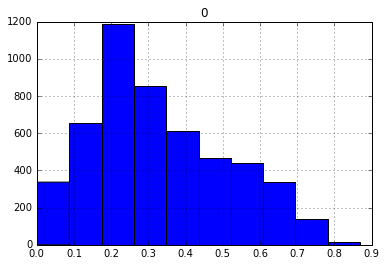

In [147]:
result=result2
print (np.median(result))
print (np.mean(result))
prediction = pd.DataFrame( result )
prediction.hist(column=0)
result[result >= 0.32] = 1
result[result < 0.32] = 0

prediction[0].value_counts
prediction = pd.concat([test['ID'], prediction], axis=1)
prediction.to_csv('submit.csv', index=False)

prediction.columns = ['ID', 'Business_Sourced']
print(prediction['Business_Sourced'].value_counts())
timestr = time.strftime("%Y%m%d-%H%M%S")
prediction.to_csv('draft_gb1'+timestr+'.csv', index=False)

In [25]:
test_x.to_csv('test_predict.csv', index=False)
train['Business_Sourced'].value_counts()
test_x.head()

,Office_PIN,Application_Receipt_Date,Applicant_City_PIN,Manager_Num_Application,Manager_Num_Coded,Manager_Business,Manager_Num_Products,Manager_Business2,Manager_Num_Products2,Applicant_Age,...,Manager_Grade_5.0,Manager_Grade_6.0,Manager_Grade_7.0,Manager_Grade_8.0,Manager_Grade_9.0,Manager_Grade_10.0,Manager_Status_Confirmation,Manager_Status_Probation,Manager_Gender_F,Manager_Gender_M
9527,33,7,1019,1.0,0.0,10,0.0,10,0.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9528,84,7,3300,2.0,0.0,10,0.0,10,0.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9529,84,7,0,0.0,0.0,5314,0.0,5292,0.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9530,84,7,3656,0.0,0.0,5314,0.0,5292,0.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9531,66,7,2115,4.0,1.0,5271,3.0,5247,3.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [254]:
t = pd.DataFrame(prediction)
t = pd.concat([test_x[test_x.columns], prediction], axis=1)
#test_x.head()
train_y.head()

,0
0,0
1,1
2,0
3,0
4,0
